In [16]:
from pprint import pprint
from typing import List

import numpy as np
import pandas as pd

from src.utilities.constants import (
    LYS_BONDS,
    LIP_BONDS,
    OVA_BONDS,
    BSA_BONDS,
    LYS,
    LIP,
    BSA,
    OVA,
    PROTON,
)
from src.model.fragment import Fragment
from src.model.precursor import Precursor
from src.utilities.dataloading import load_fragment_matches, load_precursor_matches
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx

import itertools

from src.model.variant import Variant

PROTEIN = "LYS"
SEGMENTS = 3
BREAKS = 2

KIND = "AT"
ERROR = 10
CODE = None

# Visualising
CMAP = plt.get_cmap("PiYG")
CYSTEINES = []
TRUE_BONDS = []


def get_cysteines(sequence):
    return [i for i, res in enumerate(sequence) if res == "C"]


if PROTEIN == "LYS":
    CYSTEINES = get_cysteines(LYS)
    TRUE_BONDS = LYS_BONDS
elif PROTEIN == "LIP":
    CYSTEINES = get_cysteines(LIP)
    TRUE_BONDS = LIP_BONDS
elif PROTEIN == "OVA" or PROTEIN == "TEST_OVA":
    CYSTEINES = get_cysteines(OVA)
    TRUE_BONDS = OVA_BONDS
elif PROTEIN == "BSA":
    CYSTEINES = get_cysteines(BSA)
    TRUE_BONDS = BSA_BONDS

CYSTEINES

[5, 29, 63, 75, 79, 93, 114, 126]

In [3]:
precursor_matches = load_precursor_matches(
    protein=PROTEIN, kind=KIND, segments=SEGMENTS, error=ERROR, code=CODE
)
precursor_matches[:2]

Loading precursors from ../out/precursor_matches/LYS_AT_segments=3_error=10ppm.pickle...


[{'scan': <src.model.scan.Scan at 0x105c36a60>,
  'precursor': Precursor(sequence='CELAAAMK+GCR', mass=1186.53824505928, mz=395.51274835309334, segments=[(2, 3), (16, 17)], residue_ranges=[(5, 13), (125, 128)], cys_bond_count=1, alkylation_count=0, modifications=[Modification(description='Met Oxidation', mass=15.9949)], error_ppm=0.17497809442811452)},
 {'scan': <src.model.scan.Scan at 0x105c475e0>,
  'precursor': Precursor(sequence='RHGLDNYR', mass=1031.5260753487098, mz=515.7630376743549, segments=[(3, 5)], residue_ranges=[(13, 21)], cys_bond_count=0, alkylation_count=0, modifications=[], error_ppm=0.046330920919352085)}]

In [4]:
fragment_matches = load_fragment_matches(
    protein=PROTEIN, kind=KIND, segments=SEGMENTS, breaks=BREAKS, error=ERROR, code=CODE
)
fragment_matches[:3]

Loading fragments from ../out/fragment_matches/LYS_AT_segments=3_breaks=2_error=10ppm.pickle


[{'scan': <src.model.scan.Scan at 0x105842b50>,
  'precursor': Precursor(sequence='CELAAAMK+GCR', mass=1186.53824505928, mz=395.51274835309334, segments=[(2, 3), (16, 17)], residue_ranges=[(5, 13), (125, 128)], cys_bond_count=1, alkylation_count=0, modifications=[Modification(description='Met Oxidation', mass=15.9949)], error_ppm=0.17497809442811452),
  'variant': <src.model.variant.Variant at 0x105c474c0>,
  'variant_count': 1,
  'fragment': Fragment(id=13, sequence='C+CR', residue_ranges=[(5, 6), (126, 128)], intensity=55958.6640625, intensity_ratio=0.004537294445466775, mass=362.11948059302, target_mass=360.10612533586, mz=181.05974029651, target_mz=181.0608877, charge=2, break_count=2, error_ppm=6.372625852435844, modifications=(Modification(description='-H2O (neutral loss)', mass=-18.0105646837),), connected_bonds=[(5, 126)], disconnected_cys=[])},
 {'scan': <src.model.scan.Scan at 0x105842b50>,
  'precursor': Precursor(sequence='CELAAAMK+GCR', mass=1186.53824505928, mz=395.512748

In [5]:

def var_is_good(fragment_match):
    v: Variant = fragment_match["variant"]
    bond_cys = set(c for b in TRUE_BONDS for c in b)
    seen_cys = False

    for c in CYSTEINES:
        if v[c] is not None:
            has_partner = (partner := v.bond_partner(c)) is not None
            bad_bond = has_partner and c < partner and (c, partner) not in TRUE_BONDS
            bad_alkylation = not has_partner and c in bond_cys
            if bad_bond or bad_alkylation:
                return False
            seen_cys = True

    if seen_cys:
        return True


records = [
    fm["scan"].to_dict()
    | fm["precursor"].to_dict()
    | fm["variant"].to_dict()
    | (fm["fragment"].to_dict() if fm["fragment"] is not None else {})
    | {"prec_variant_count": fm["variant_count"], "var_is_good": var_is_good(fm)}
    for fm in fragment_matches
]

records[:3]

[{'scan_id': 845,
  'scan_nth_in_order': 57,
  'scan_time': 362.4916492 second,
  'scan_total_intensity': 12333046.650390625,
  'prec_charge': 3,
  'prec_sequence': 'CELAAAMK+GCR',
  'prec_segment_count': 2,
  'prec_tryptide_ranges': [(2, 3), (16, 17)],
  'prec_residue_ranges': [(5, 13), (125, 128)],
  'prec_max_mc_count': 0,
  'prec_mc': [0, 0],
  'prec_cys_bond_count': 1,
  'prec_mass': 1186.53824505928,
  'prec_mz': 395.51274835309334,
  'prec_error': 0.17497809442811452,
  'prec_alkylation_count': 0,
  'prec_mods': ['Met Oxidation'],
  'var_bonds': [(5, 126)],
  'frag_id': 13,
  'frag_sequence': 'C+CR',
  'frag_residue_ranges': [(5, 6), (126, 128)],
  'frag_charge': 2,
  'frag_mass': 362.11948059302,
  'frag_mz': 181.05974029651,
  'frag_break_count': 2,
  'frag_error_ppm': 6.372625852435844,
  'frag_mods': ['-H2O (neutral loss)'],
  'frag_connected_bonds': [(5, 126)],
  'frag_disconnected_cys': [],
  'frag_interesting_disconnected_cys': [],
  'frag_intensity': 55958.6640625,
  'fr

In [6]:
df = pd.DataFrame(records)


def stringify(df, column):
    res = []
    for rs in df[column]:
        res.append(" + ".join([str(r) for r in rs]) if rs is not np.nan else pd.NA)
    df[column] = res


for c in [
    "prec_tryptide_ranges",
    "prec_residue_ranges",
    "prec_mods",
    "prec_mc",
    "var_bonds",
    "frag_residue_ranges",
    "frag_mods",
    "frag_connected_bonds",
    "frag_disconnected_cys",
    "frag_interesting_disconnected_cys",
]:
    stringify(df, c)

df

,scan_id,scan_nth_in_order,scan_time,scan_total_intensity,prec_charge,prec_sequence,prec_segment_count,prec_tryptide_ranges,prec_residue_ranges,prec_max_mc_count,...,frag_mods,frag_connected_bonds,frag_disconnected_cys,frag_interesting_disconnected_cys,frag_intensity,frag_intensity_ratio,target_mass,target_mz,prec_variant_count,var_is_good
0,845,57,362.491649,1.233305e+07,3,CELAAAMK+GCR,2,"(2, 3) + (16, 17)","(5, 13) + (125, 128)",0,...,-H2O (neutral loss),"(5, 126)",,,55958.664062,0.004537,360.106125,181.060888,1,True
1,845,57,362.491649,1.233305e+07,3,CELAAAMK+GCR,2,"(2, 3) + (16, 17)","(5, 13) + (125, 128)",0,...,,"(5, 126)",,,20921.298828,0.001696,390.068367,391.076192,1,True
2,845,57,362.491649,1.233305e+07,3,CELAAAMK+GCR,2,"(2, 3) + (16, 17)","(5, 13) + (125, 128)",0,...,-H2O (neutral loss),"(5, 126)",,,30266.029297,0.002454,546.166189,547.174014,1,True
3,845,57,362.491649,1.233305e+07,3,CELAAAMK+GCR,2,"(2, 3) + (16, 17)","(5, 13) + (125, 128)",0,...,-H2O (neutral loss),"(5, 126)",,,69405.210938,0.005628,546.166746,274.091198,1,True
4,845,57,362.491649,1.233305e+07,3,CELAAAMK+GCR,2,"(2, 3) + (16, 17)","(5, 13) + (125, 128)",0,...,-NH3 (neutral loss),"(5, 126)",,,56152.218750,0.004553,547.150257,548.158082,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97034,14392,12470,1794.330030,2.810368e+04,3,CELAAAMK+NLCNIPCSALLSSDITASVNCAK+NRCKGTDVQAWIR,3,"(2, 3) + (10, 11) + (13, 16)","(5, 13) + (73, 96) + (112, 125)",2,...,-H2O (neutral loss),"(75, 114)",,,1057.635742,0.037633,1538.712834,1539.720659,6,False
97035,14392,12470,1794.330030,2.810368e+04,3,CELAAAMK+NLCNIPCSALLSSDITASVNCAK+NRCKGTDVQAWIR,3,"(2, 3) + (10, 11) + (13, 16)","(5, 13) + (73, 96) + (112, 125)",2,...,-NH3 (neutral loss) + -NH3 (neutral loss),,,,1367.881592,0.048673,1594.761938,1595.769763,6,False
97036,14392,12470,1794.330030,2.810368e+04,3,CELAAAMK+NLCNIPCSALLSSDITASVNCAK+NRCKGTDVQAWIR,3,"(2, 3) + (10, 11) + (13, 16)","(5, 13) + (73, 96) + (112, 125)",2,...,-NH3 (neutral loss) + -NH3 (neutral loss),,,,1367.881592,0.048673,1594.761938,1595.769763,6,False
97037,14392,12470,1794.330030,2.810368e+04,3,CELAAAMK+NLCNIPCSALLSSDITASVNCAK+NRCKGTDVQAWIR,3,"(2, 3) + (10, 11) + (13, 16)","(5, 13) + (73, 96) + (112, 125)",2,...,-NH3 (neutral loss),,,,922.451294,0.032823,426.178961,214.097306,6,False


In [7]:
csv_path = (
    "../out/csv/fragment_matches_{}_{}_segments={}_breaks={}_error={}ppm{}.csv".format(
        PROTEIN, KIND, SEGMENTS, BREAKS, ERROR, "" if CODE is None else f"_{CODE}"
    )
)
print(f"Saving to {csv_path}")
df.to_csv(csv_path, index_label="id", sep=";")

Saving to ../out/csv/fragment_matches_LYS_AT_segments=3_breaks=2_error=10ppm.csv


In [6]:

def draw(graph, node_scores, edge_scores):
    plt.figure(figsize=(5, 5), dpi=200)
    node_colors = [CMAP(float(s)) for s in node_scores]
    edge_colors = [CMAP(float(s)) for s in edge_scores]
    return nx.draw_circular(
        graph,
        with_labels=True,
        node_size=1200,
        font_size=12,
        node_color="#E7DBB7",
        linewidths=2,
        arrowsize=10,
        edgecolors=node_colors,
        edge_color=edge_colors,
        width=[0.3 if sc < 0.5 else 2 for sc in edge_scores],
        connectionstyle="arc3,rad=0.2",
    )


def visualise_ideal(cysteines: List[int]):
    nodes = reversed(cysteines[3:] + cysteines[:3])
    g = nx.DiGraph(nx.complete_graph(nodes))
    edge_scores = [tuple(sorted(e)) in TRUE_BONDS for e in g.edges()]
    node_scores = [not any(n in b for b in TRUE_BONDS) for n in g.nodes()]

    return draw(g, node_scores, edge_scores)


def compute_prec_probabilities(fragment_matches):
    tryptide_count = Counter()
    for match in precursor_matches:
        precursor: Precursor = match["precursor"]
        for sb, se in precursor.segments:
            for t in range(sb, se):
                tryptide_count[t] += 1

    total = sum(tryptide_count.values())
    tryptide_probability = {}
    for t, count in tryptide_count.items():
        tryptide_probability[t] = count / total

    precursor_probability = []
    for match in fragment_matches:
        probability = 1
        precursor: Precursor = match["precursor"]
        for sb, se in precursor.segments:
            for t in range(sb, se):
                probability *= tryptide_probability[t]
        precursor_probability.append(probability)

    return precursor_probability


faulty_matches = []


def calculate_scores(fragment_matches, probs, cysteines: List[int], weight):
    possible_bonds = list(itertools.combinations(cysteines, 2))
    positive_evidence = {b: 0 for b in possible_bonds}
    negative_evidence = {b: 0 for b in possible_bonds}
    alkylation_score = {c: 0 for c in cysteines}

    DIRECT_POS_WEIGHT = 1
    NEG_WEIGHT = 1
    INDIRECT_POS_WEIGHT = 0
    NEG_ALK_WEIGHT = 0.1

    for match, prob in zip(fragment_matches, probs):
        fragment: Fragment = match["fragment"]

        if fragment is None:
            continue

        P = weight(match)
        cys_in_bonds = []

        for b in fragment.connected_bonds:
            positive_evidence[b] += P * DIRECT_POS_WEIGHT
            cys_in_bonds += list(b)
            for x, y in negative_evidence:
                if (x, y) != b and (x in b or y in b):
                    # We're looking at A<–>B, every other bond with A or B is decreased
                    negative_evidence[(x, y)] += P * NEG_WEIGHT

        for c in fragment.disconnected_cys:
            # TODO: Check if only interesting matter
            cys_in_bonds.append(c)
            for b in positive_evidence:
                if c in b:
                    positive_evidence[b] += P * INDIRECT_POS_WEIGHT

        if len(cys_in_bonds) != len(set(cys_in_bonds)):
            faulty_matches.append(match)
            # assert len(cys_in_bonds) == len(set(cys_in_bonds))

        for c in cysteines:
            if c not in cys_in_bonds and any(
                b <= c < e for b, e in fragment.residue_ranges
            ):
                alkylation_score[c] += P * NEG_ALK_WEIGHT

    return positive_evidence, negative_evidence, alkylation_score


def intersects(t1, t2):
    return t1[0] in t2 or t1[1] in t2


def score(e, positive, negative, alkylation):
    return positive[e]


def normalize(x, xs):
    return abs(x - min(xs)) / abs(max(xs) - min(xs))


def visualise(cysteines: List[int], pos_evidence, neg_evidence, alk_evidence):
    nodes = list(reversed(cysteines[3:] + cysteines[:3]))
    g = nx.DiGraph(nx.complete_graph(nodes))

    scores = [
        (e, score(tuple(sorted(e)), pos_evidence, neg_evidence, alk_evidence))
        for e in g.edges()
    ]
    node_scores = [(n, alk_evidence[n]) for n in nodes]

    scores_normalized = [
        normalize(
            esc,
            [n for f, n in scores if f[0] == e[0]]
            + [nsc for node, nsc in node_scores if node == e[0]],
        )
        for e, esc in scores
    ]
    node_scores_normalized = [
        normalize(s, [n for f, n in scores if f[0] == node]) for node, s in node_scores
    ]

    return draw(g, node_scores_normalized, scores_normalized)


In [7]:
prec_probs = compute_prec_probabilities(fragment_matches)
prec_probs[:3]

[0.008255990874870759, 0.008255990874870759, 0.008255990874870759]

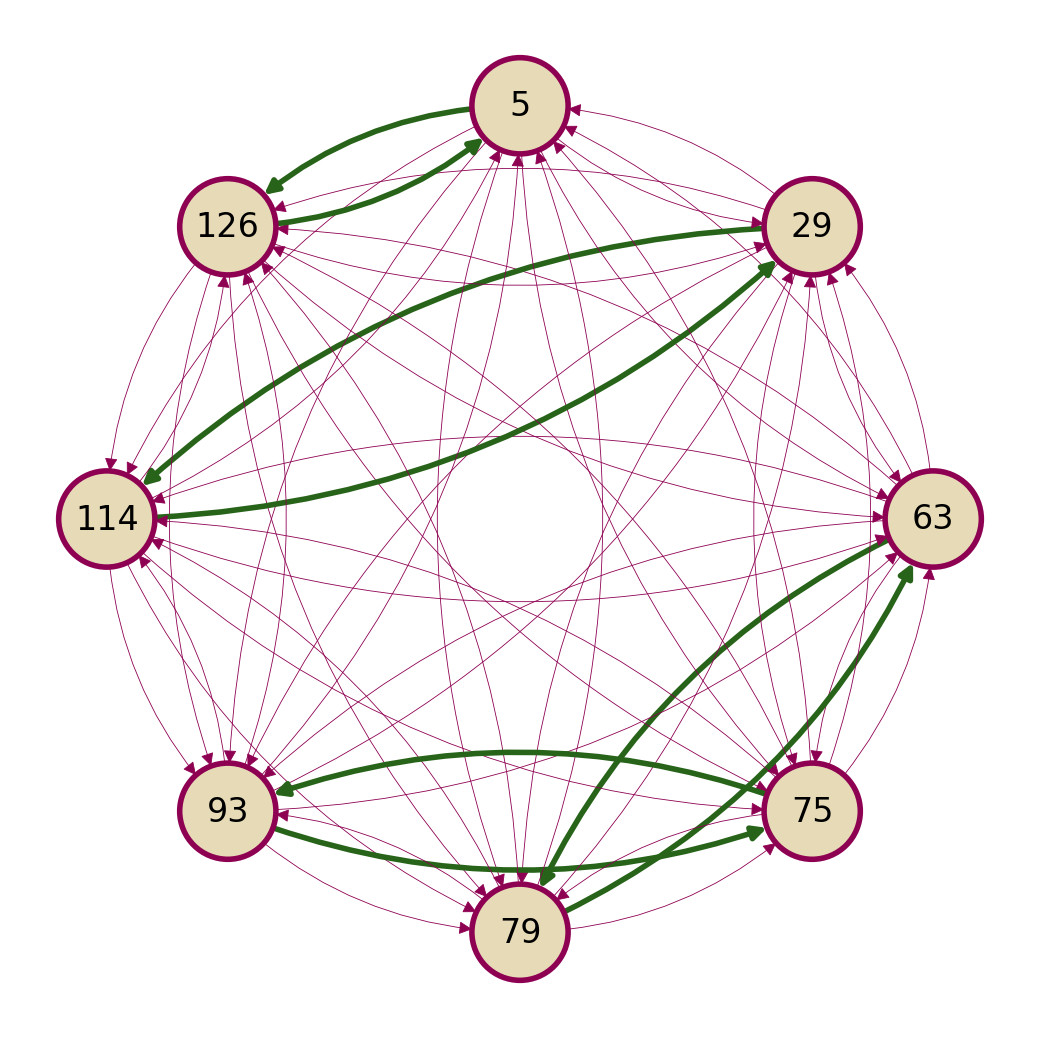

In [8]:
visualise_ideal(CYSTEINES)


In [9]:

def match_probability(match):
    prec: Precursor = match["precursor"]
    frag: Fragment = match["fragment"]
    variant: Variant = match["variant"]
    top = (
        1
        if (
            (63, 114) not in frag.connected_bonds
            and (79, 114) not in frag.connected_bonds
            and (75, 114) not in frag.connected_bonds
            and (93, 114) not in frag.connected_bonds
            and (63, 126) not in frag.connected_bonds
            and (79, 126) not in frag.connected_bonds
            and (75, 126) not in frag.connected_bonds
            and (93, 126) not in frag.connected_bonds
        )
        else 0.5
    )
    # top = prec.error_ppm < 10

    return top / (prec.error_ppm + prec.to_dict()["prec_max_mc_count"] + 0.001)


pos, neg, alk = calculate_scores(
    fragment_matches, prec_probs, CYSTEINES, weight=match_probability
)

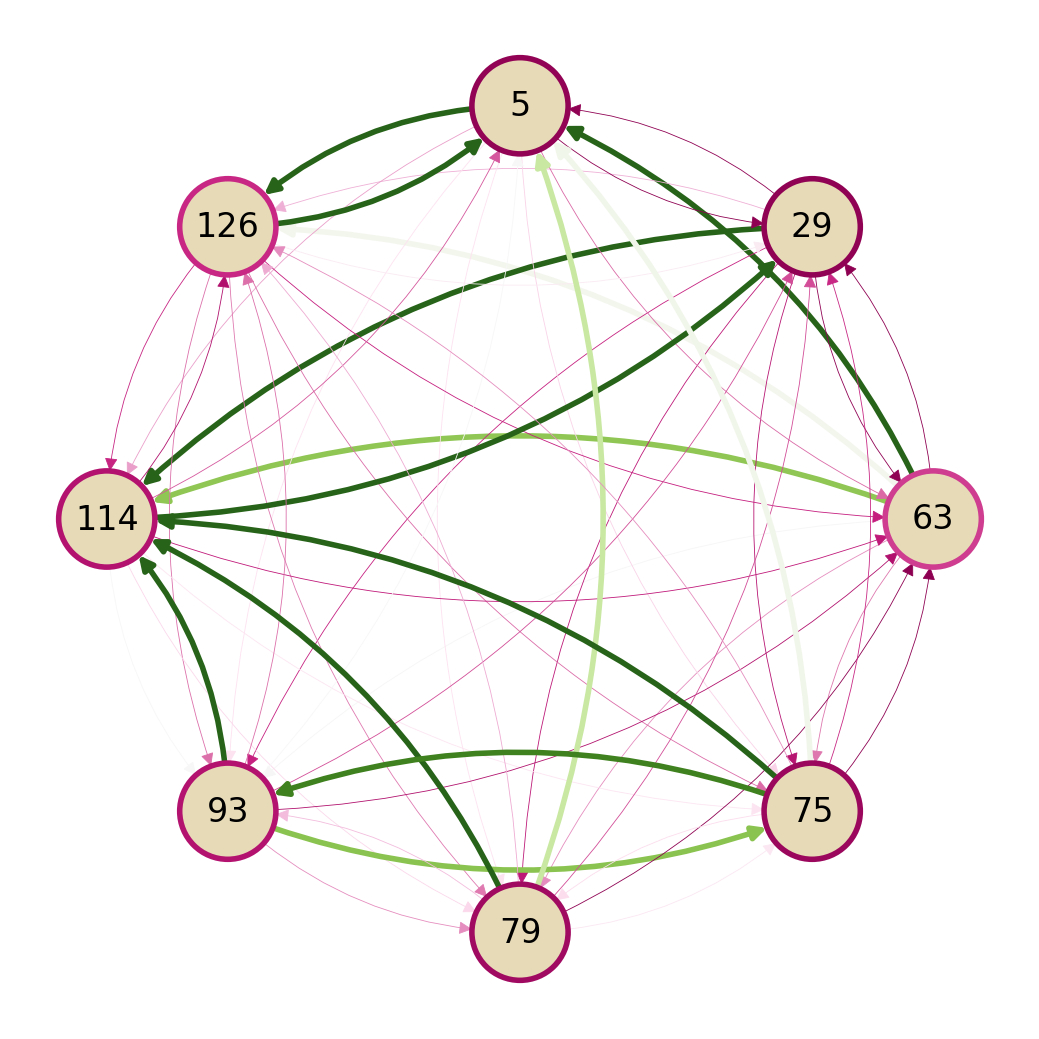

In [10]:
visualise(CYSTEINES, pos, neg, alk)


In [11]:

import importlib
import fragment_matching
import src.model.precursor

importlib.reload(fragment_matching)
importlib.reload(src.model.precursor)

<module 'src.model.precursor' from '/Users/eugen/code/bp/bp-code/src/model/precursor.py'>

In [34]:
frag = faulty_matches[0]["fragment"]
prec = faulty_matches[0]["precursor"]
var = faulty_matches[0]["variant"]

fragment_matching._fragments_matching_targets(
    [fragment_matching.Target(0, frag.target_mz, frag.target_mass, 10, 6, 1)],
    var,
    2,
    5,
)

[]

In [31]:
sum(seg for seg in frag.sequence.split("+"))

'YSLGNWVCAAK+CKGTDVQAWIRGCR+PCSALLSSDITASVNCAKK+NLCNIPCSALLSSDITASVNCAKK'

In [35]:
prec.sequence

'CELAAAMKRHGLDNYRGYSLGNWVCAAK+NLCNIPCSALLSSDITASVNCAKK+CKGTDVQAWIRGCR'